# Load multiband raster data via stream API

In [1]:
import warnings
from datetime import datetime

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import geoengine as ge

# setting `clip_to_query_rectangle=True` may output a warning, but this is a false positive from the underlying library
warnings.simplefilter(action="ignore", category=FutureWarning)

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030/api")

## Define workflow of a stacked raster of ndvi and land cover

In [3]:
workflow = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "RasterStacker",
            "params": {"renameBands": {"type": "default"}},
            "sources": {
                "rasters": [
                    {"type": "GdalSource", "params": {"data": "ndvi"}},
                    {"type": "GdalSource", "params": {"data": "land_cover"}},
                ]
            },
        },
    }
)
workflow

943fdaec-581a-596d-817e-66e7b1f11bc0

## Define a query rectangle

In [4]:
time_start = datetime.strptime("2014-04-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime("2014-06-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time_start, time_end),
    ge.SpatialResolution(0.5, 0.5),
)

# Query single tiles, merge them locally and output them as a single `DataArray`

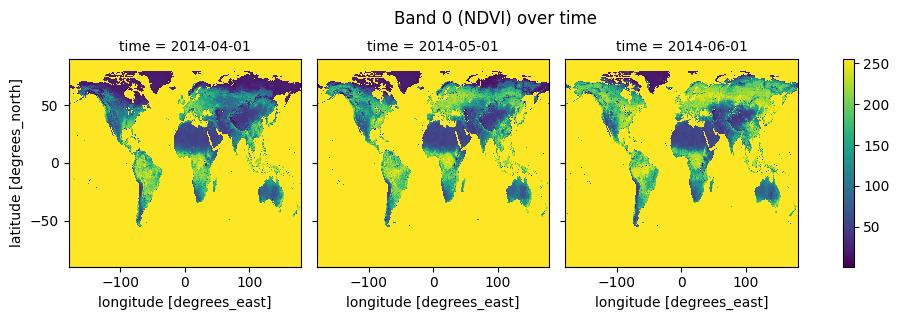

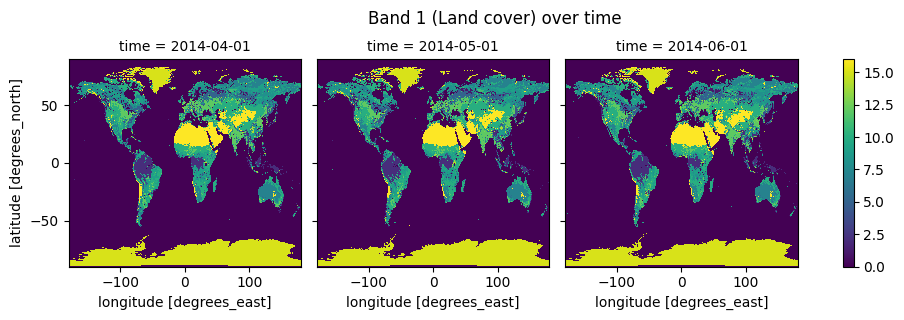

In [5]:
array = await workflow.raster_stream_into_xarray(bbox, bands=[0, 1], clip_to_query_rectangle=True)

array.isel(band=0).plot(col="time")
plt.suptitle("Band 0 (NDVI) over time", y=1.05)
plt.show()

array.isel(band=1).plot(col="time")
plt.suptitle("Band 1 (Land cover) over time", y=1.05)
plt.show()

## Output structure of the array

In [6]:
array.to_dataset(name="Multi-Band")

<xarray.Dataset> Size: 156MB
Dimensions:      (x: 3601, y: 1800, time: 3, band: 2)
Coordinates:
  * x            (x) float64 29kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time         (time) datetime64[ns] 24B 2014-04-01 2014-05-01 2014-06-01
  * band         (band) int64 16B 0 1
    spatial_ref  int64 8B 0
Data variables:
    Multi-Band   (time, band, y, x) float32 156MB 255.0 255.0 255.0 ... 0.0 nan

## Define a multi-band raster as a an RGB composite

In [7]:
workflow = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "RasterStacker",
            "params": {"renameBands": {"type": "default"}},
            "sources": {
                "rasters": [
                    {"type": "GdalSource", "params": {"data": "ne2_raster_red"}},
                    {"type": "GdalSource", "params": {"data": "ne2_raster_green"}},
                    {"type": "GdalSource", "params": {"data": "ne2_raster_blue"}},
                ]
            },
        },
    }
)

array = await workflow.raster_stream_into_xarray(bbox, bands=[0, 1, 2], clip_to_query_rectangle=True)

array.to_dataset(name="rgb")

<xarray.Dataset> Size: 78MB
Dimensions:      (x: 3601, y: 1800, time: 1, band: 3)
Coordinates:
  * x            (x) float64 29kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time         (time) datetime64[ns] 8B 1678-09-21T00:12:43.145224192
  * band         (band) int64 24B 0 1 2
    spatial_ref  int64 8B 0
Data variables:
    rgb          (time, band, y, x) float32 78MB 103.0 103.0 103.0 ... 249.0 nan

## Plot the bands individually

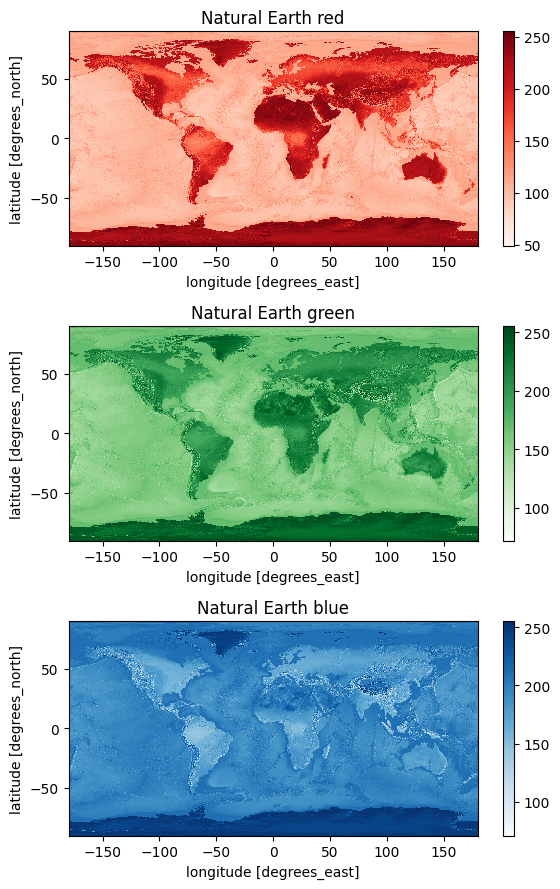

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9))

cmap = plt.get_cmap("Reds")
norm = mcolors.Normalize(vmin=0, vmax=255)
array.isel(band=0).plot(cmap=cmap, ax=axs[0])
axs[0].set_title("Natural Earth red")

cmap = plt.get_cmap("Greens")
norm = mcolors.Normalize(vmin=0, vmax=255)
array.isel(band=1).plot(cmap=cmap, ax=axs[1])
axs[1].set_title("Natural Earth green")

cmap = plt.get_cmap("Blues")
norm = mcolors.Normalize(vmin=0, vmax=255)
array.isel(band=2).plot(cmap=cmap, ax=axs[2])
axs[2].set_title("Natural Earth blue")

plt.tight_layout()
plt.show()

## Plot the RGB composite

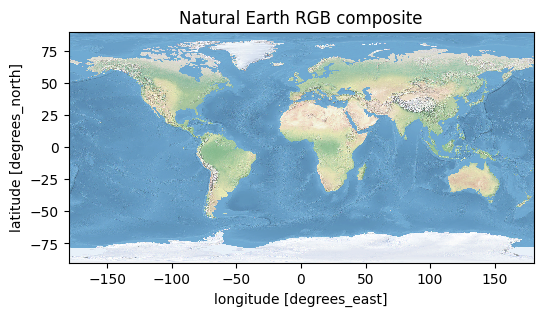

In [9]:
plt.figure(figsize=(6, 3))

array.fillna(0).isel(time=0, drop=True).astype("int").plot.imshow(rgb="band")

plt.title("Natural Earth RGB composite")
plt.show()